Training set size: 13900 samples
Testing set size: 3476 samples

Model Evaluation:
Mean Squared Error (MSE): 0.44
Root Mean Squared Error (RMSE): 0.66
R-squared (R2): 1.0000


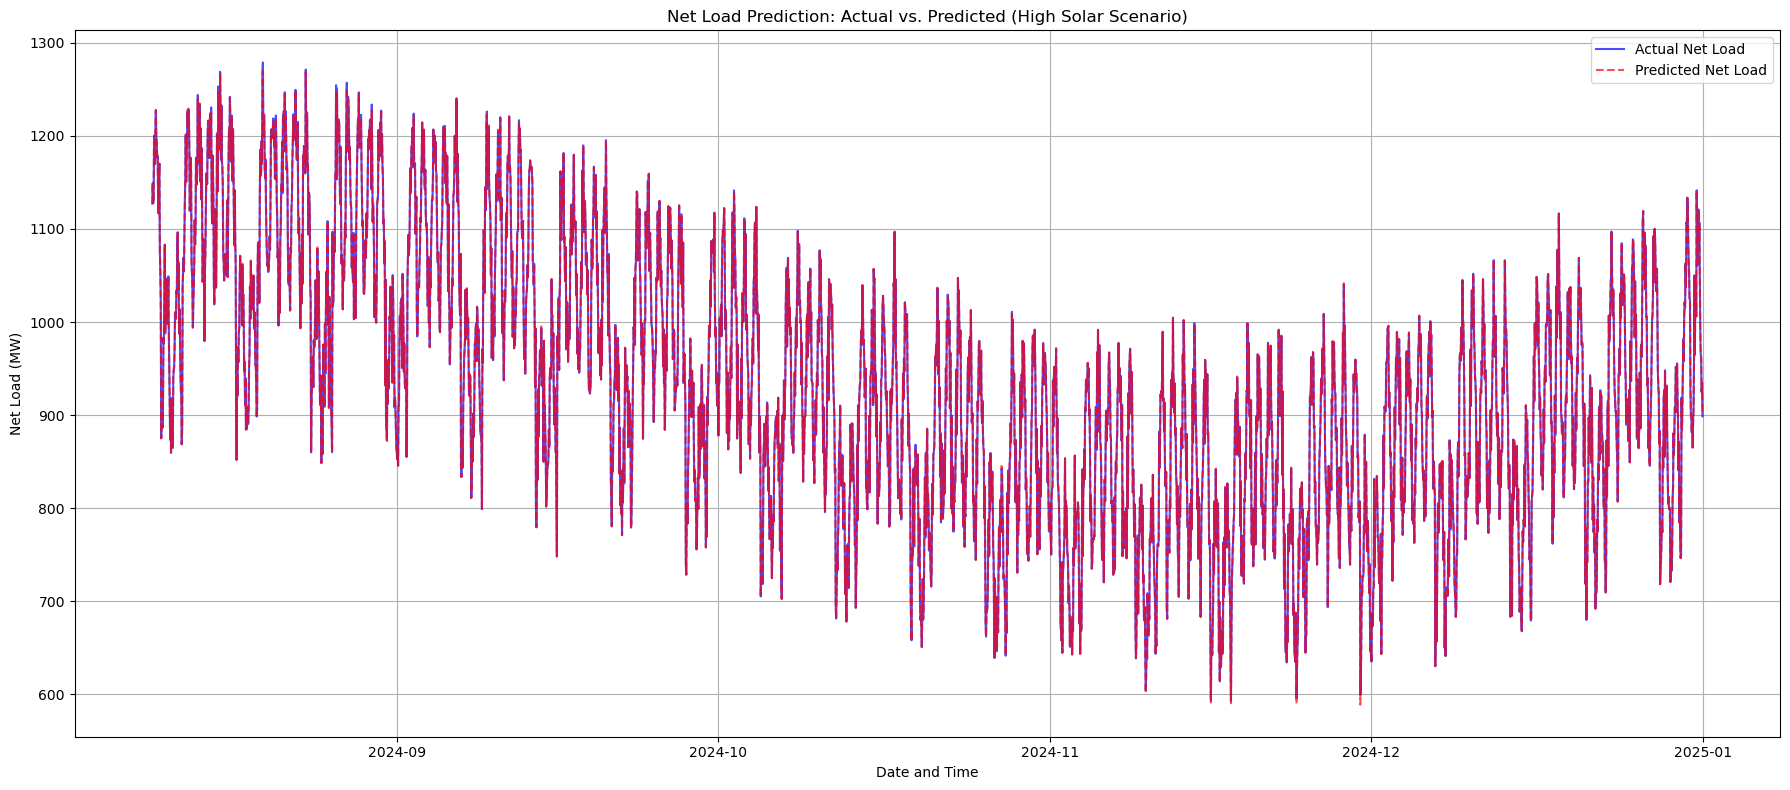

/var/folders/0_/3wtwj_757vq885qd_y8v6b2w0000gn/T/ipykernel_21131/920815390.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


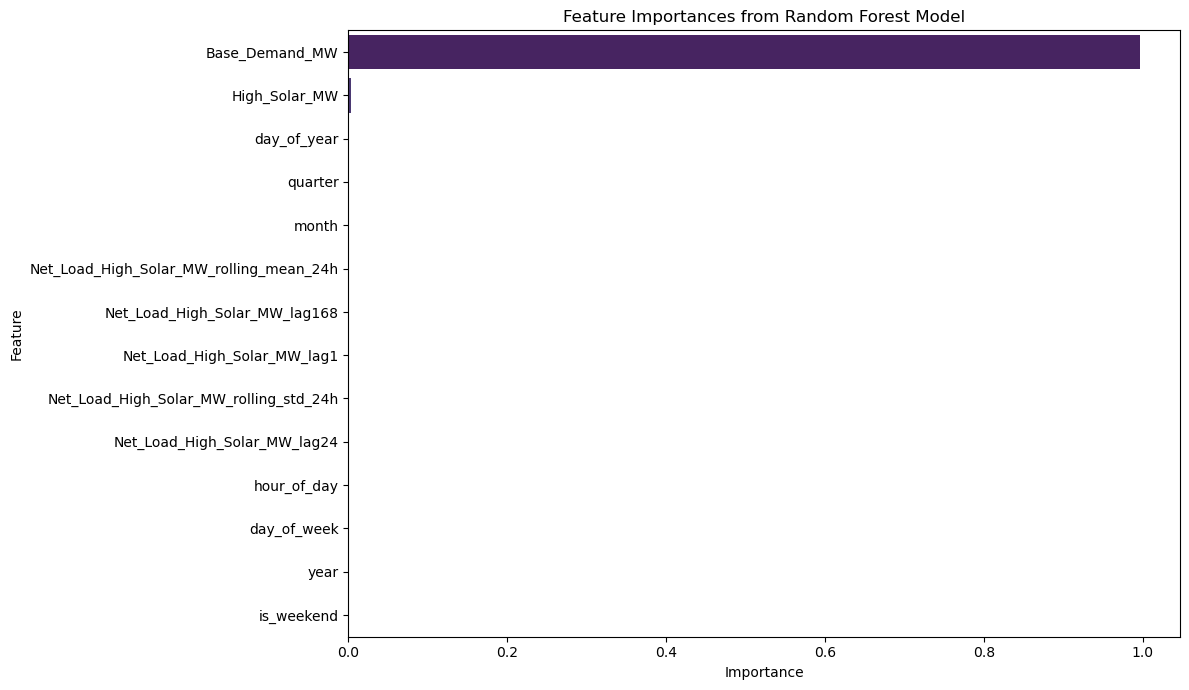

In [5]:
# Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load Your Data
df = pd.read_csv('simulated_eon_grid_data.csv', index_col=0, parse_dates=True)

# Feature Engineering
# Time-based features
df['hour_of_day'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['day_of_year'] = df.index.dayofyear
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['is_weekend'] = ((df.index.dayofweek == 5) | (df.index.dayofweek == 6)).astype(int)

# Lagged features for demand (e.g., demand from 24 hours ago)
# We will create lagged features for 'Net_Load_High_Solar_MW' as it's our target
df['Net_Load_High_Solar_MW_lag1'] = df['Net_Load_High_Solar_MW'].shift(1)
df['Net_Load_High_Solar_MW_lag24'] = df['Net_Load_High_Solar_MW'].shift(24)
df['Net_Load_High_Solar_MW_lag168'] = df['Net_Load_High_Solar_MW'].shift(168) # 7 days ago

# Rolling window features (e.g., 24-hour moving average of demand)
df['Net_Load_High_Solar_MW_rolling_mean_24h'] = df['Net_Load_High_Solar_MW'].rolling(window=24).mean()
df['Net_Load_High_Solar_MW_rolling_std_24h'] = df['Net_Load_High_Solar_MW'].rolling(window=24).std()

# Drop rows with NaN values created by shifting/rolling (these are at the beginning of the DataFrame)
df.dropna(inplace=True)

# Define Features (X) and Target (y)
# We will predict 'Net_Load_High_Solar_MW'
features = [
    'hour_of_day', 'day_of_week', 'day_of_year', 'month', 'quarter', 'year', 'is_weekend',
    'Net_Load_High_Solar_MW_lag1', 'Net_Load_High_Solar_MW_lag24', 'Net_Load_High_Solar_MW_lag168',
    'Net_Load_High_Solar_MW_rolling_mean_24h', 'Net_Load_High_Solar_MW_rolling_std_24h',
    'Base_Demand_MW', 'High_Solar_MW' # Include original demand and solar output as features
]
target = 'Net_Load_High_Solar_MW'

X = df[features]
y = df[target]

# Split Data into Training and Testing Sets
# Use a time-series split to avoid data leakage (train on past, test on future)
train_size = int(len(df) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

# Model Training (Random Forest Regressor)
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 uses all available cores
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.4f}")

# Visualize Predictions vs. Actual
plt.figure(figsize=(18, 8))
plt.plot(y_test.index, y_test, label='Actual Net Load', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='Predicted Net Load', color='red', linestyle='--', alpha=0.7)
plt.title('Net Load Prediction: Actual vs. Predicted (High Solar Scenario)')
plt.xlabel('Date and Time')
plt.ylabel('Net Load (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize Feature Importance
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
plt.title('Feature Importances from Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()